In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import pandas as pd
import numpy as np
from sglm.helpers import filehelpers
from pathlib import Path

In [4]:
base_location = Path(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs')

# load_folder = base_location / Path(r'Figure_1_2')
# h5_beta_locations = str((load_folder / Path(r'all\f1*-ft\coefs\*_best_coeffs.h5')).resolve())
# load_folder = base_location / Path(r'Figure_3')
# h5_beta_locations = str((load_folder / Path(r'all\f3*-ft\coefs\*_best_coeffs.h5')).resolve())
# load_folder = base_location / Path(r'Figure_4_g1')
# h5_beta_locations = str((load_folder / Path(r'all\f4*-ft\coefs\*_best_coeffs.h5')).resolve())
# load_folder = base_location / Path(r'Figure_4_g2')
# h5_beta_locations = str((load_folder / Path(r'all\f4*-ft\coefs\*_best_coeffs.h5')).resolve())
# load_folder = base_location / Path(r'Figure_5_g1')
# h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\coefs\*_best_coeffs.h5')).resolve())
load_folder = base_location / Path(r'Figure_5_g2')
h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\coefs\*_best_coeffs.h5')).resolve())

out_folder = base_location / Path(r'final_outputs')

# h5_beta_locations = Path('/Users/josh/Dropbox (HMS)/jz/Tetanus/1194_1195_1214_1258_1259_2_best_coeffs.h5')
out_loc = str((out_folder).resolve())
h5_beta_locations = glob.glob(h5_beta_locations)

In [5]:
h5_lst = []
for h5_coef_fn in h5_beta_locations:
    h5f = pd.HDFStore(h5_coef_fn)
    h5fk = h5f.keys()
    for key in h5fk:
        h5_df = pd.read_hdf(h5f, key).reset_index()
        h5_df['fn'] = h5_coef_fn
        h5_df['key'] = key
        h5_df = h5_df.set_index(['fn','key'])
        
        
        h5_df = h5_df.sort_values('channel_name')
        h5_df['channel'] = h5_df['channel_name'].str.split('_').apply(lambda x: x[0])
        h5_df['run_num'] = h5_df['channel_name'].str.split('_').apply(lambda x: x[-1])
        
        h5_lst.append(h5_df)
concat = pd.concat(h5_lst, axis=0)

In [6]:
filehelpers.create_folder_if_not_exists(out_loc)

In [7]:
base_keys = list({
                # 'gACH':(0,0),
                # 'rDA':(0,0),
                # 'gDA':(0,0),
                'photometryCenterInIndex':(0,0),
                'photometryCenterOutIndex':(0,0),
                'photometrySideInIndex':(0,0),
                'photometrySideInIndexr':(0,0),
                'photometrySideOutIndex':(0,0),
                'sl': (0,0),
                'spnnrOff': (0,0),
                'photometryCenterInIndex':(0,0),
                'photometryCenterOutIndex':(0,0),
                'photometrySideInIndexAA':(0,0),
                'photometrySideInIndexAa':(0,0),
                'photometrySideInIndexaA':(0,0),
                'photometrySideInIndexaa':(0,0),
                'photometrySideInIndexAB':(0,0),
                'photometrySideInIndexAb':(0,0),
                'photometrySideInIndexaB':(0,0),
                'photometrySideInIndexab':(0,0),
                'photometrySideOutIndex':(0,0),
                'sl': (0,0),
                'spnnrOff': (0,0),
                }.keys())
# base_keys

In [8]:
save_mse_scatter = concat.reset_index().set_index(['mouse_id', 'channel', 'name', 'run_num'])[['mse_tr', 'mse_cv', 'mse_te']]
save_mse_scatter.to_csv(str((Path(out_loc) / f'{load_folder.parts[-1]}-mse_sctr.csv').resolve()))

save_r2_scatter = concat.reset_index().set_index(['mouse_id', 'channel', 'name', 'run_num'])[['r2_tr', 'r2_cv', 'r2_te']]
save_r2_scatter.to_csv(str((Path(out_loc) / f'{load_folder.parts[-1]}-r2_sctr.csv').resolve()))

In [9]:
agg = concat.drop(['channel_name', 'timestamp', 'run_num'], axis=1).groupby(['channel', 'name']).agg([np.size, np.mean, np.std])
stk = agg[['mse_tr', 'mse_cv', 'mse_te']].rename({'mse_tr':'01_mse_tr', 'mse_cv':'02_mse_cv', 'mse_te':'03_mse_te'}, axis=1).swaplevel(axis=1).stack()

stk['lb'] = stk['mean'] - 1.96*stk['std']/np.sqrt(stk['size'])
stk['mn'] = stk['mean']
stk['ub'] = stk['mean'] + 1.96*stk['std']/np.sqrt(stk['size'])

plt_df = stk[['lb', 'mn', 'ub']].unstack().swaplevel(axis=1)

gACH = plt_df.loc['gACH'] if 'gACH' in plt_df.reset_index()['channel'].unique() else plt_df.iloc[0:0]
rDA = plt_df.loc['rDA'] if 'rDA' in plt_df.reset_index()['channel'].unique() else plt_df.iloc[0:0]
gDA = plt_df.loc['gDA'] if 'gDA' in plt_df.reset_index()['channel'].unique() else plt_df.iloc[0:0]

save_ci = stk[['mean', 'size', 'std']].unstack().swaplevel(axis=1).sort_index(axis=1)
save_ci.to_csv(str((Path(out_loc) / f'{load_folder.parts[-1]}-mse_ci.csv').resolve()))

In [10]:
stk

mean  size       std        lb  \
channel name                                                                    
gACH    base_simple             01_mse_tr  0.782037    10  0.001767  0.780942   
                                02_mse_cv  0.783372    10  0.003934  0.780934   
                                03_mse_te  0.786180    10  0.001727  0.785110   
        base_simple_gDA_to_gACH 01_mse_tr  0.720089    10  0.002048  0.718819   
                                02_mse_cv  0.721271    10  0.002261  0.719870   
                                03_mse_te  0.724716    10  0.002033  0.723457   
        base_simple_rDA_to_gACH 01_mse_tr  0.724690    10  0.002267  0.723284   
                                02_mse_cv  0.725741    10  0.003901  0.723324   
                                03_mse_te  0.728987    10  0.002240  0.727599   
        base_words              01_mse_tr  0.775768    10  0.001472  0.774855   
                                02_mse_cv  0.779271    10  0.002891  0.777480   
                                03_mse_te  0.780801    10  0.001435  0.779911   
        base_words_gDA_to_gACH  01_mse_tr  0.716788    20  0.003003  0.715472   
                                02_mse_cv  0.718767    20  0.003399  0.717277   
                                03_mse_te  0.722029    20  0.002897  0.720759   
        gDA_to_gACH             01_mse_tr  0.900611    10  0.003144  0.898663   
                                02_mse_cv  0.901915    10  0.005664  0.898405   
                                03_mse_te  0.902519    10  0.003220  0.900523   
        rDA_to_gACH             01_mse_tr  0.908408    10  0.002932  0.906591   
                                02_mse_cv  0.909362    10  0.003867  0.906965   
                                03_mse_te  0.909758    10  0.002969  0.907917   
gDA     base_simple             01_mse_tr  0.903595    10  0.001513  0.902657   
                                02_mse_cv  0.906301    10  0.003411  0.904187   
                                03_mse_te  0.910108    10  0.001431  0.909221   
        base_simple_gACH_to_gDA 01_mse_tr  0.837647    10  0.001759  0.836557   
                                02_mse_cv  0.840215    10  0.002895  0.838421   
                                03_mse_te  0.844574    10  0.001701  0.843519   
        base_words              01_mse_tr  0.896968    10  0.001615  0.895967   
                                02_mse_cv  0.900141    10  0.002685  0.898476   
                                03_mse_te  0.904867    10  0.001543  0.903910   
        base_words_gACH_to_gDA  01_mse_tr  0.831506    10  0.001756  0.830418   
                                02_mse_cv  0.834737    10  0.003863  0.832343   
                                03_mse_te  0.839761    10  0.001712  0.838700   
        gACH_to_gDA             01_mse_tr  0.911135    10  0.002785  0.909409   
                                02_mse_cv  0.912926    10  0.003637  0.910672   
                                03_mse_te  0.915574    10  0.002777  0.913852   
rDA     base_simple             01_mse_tr  0.800737    10  0.004840  0.797737   
                                02_mse_cv  0.801921    10  0.005291  0.798642   
                                03_mse_te  0.804674    10  0.004864  0.801659   
        base_simple_gACH_to_rDA 01_mse_tr  0.759412    10  0.004772  0.756454   
                                02_mse_cv  0.761048    10  0.005900  0.757391   
                                03_mse_te  0.763133    10  0.004793  0.760162   
        base_words              01_mse_tr  0.793019    10  0.004779  0.790058   
                                02_mse_cv  0.795018    10  0.006350  0.791082   
                                03_mse_te  0.798397    10  0.004806  0.795419   
        base_words_gACH_to_rDA  01_mse_tr  0.752315    10  0.004753  0.749369   
                                02_mse_cv  0.753409    10  0.006272  0.749522   
                                03_mse_te  0.757436    10  0.004788  0.754468 

In [11]:
import matplotlib.pyplot as plt

['', '', '', '', '', '', '']


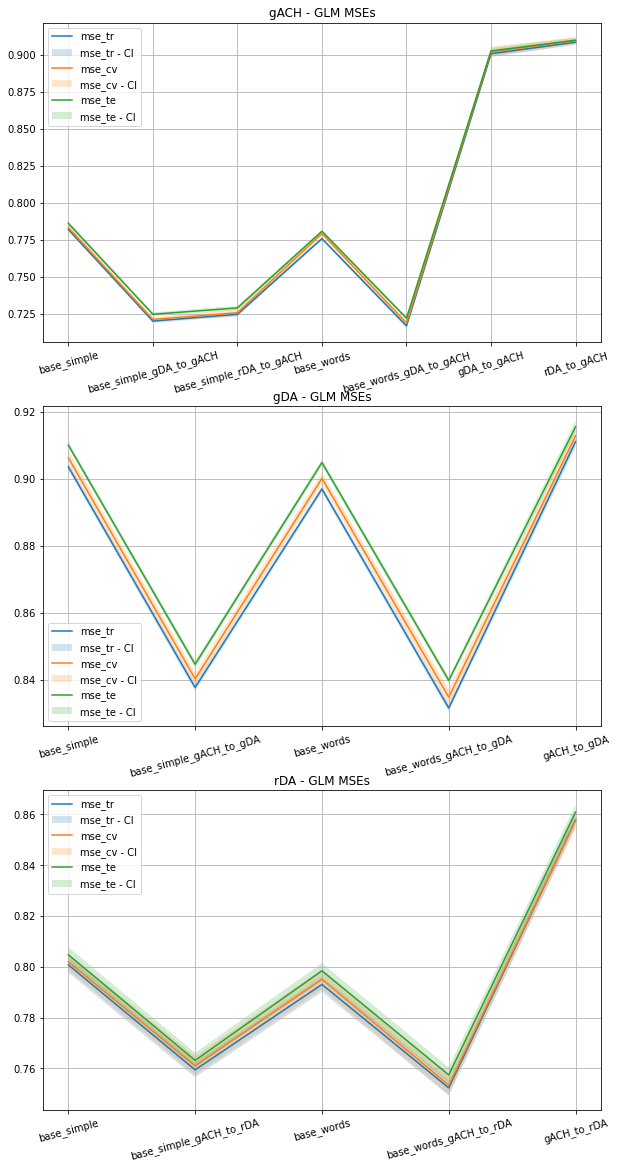

In [12]:
rot = 15

fig,axes=plt.subplots(3,1,figsize=(10,20))
fig.set_facecolor('w')

if len(gACH) > 0:
    ax = axes[0]
    ax.plot(gACH.index, gACH['01_mse_tr']['mn'], label='mse_tr')
    ax.fill_between(gACH.index, gACH['01_mse_tr']['lb'], gACH['01_mse_tr']['ub'], alpha=0.2, label='mse_tr - CI')
    ax.plot(gACH.index, gACH['02_mse_cv']['mn'], label='mse_cv')
    ax.fill_between(gACH.index, gACH['02_mse_cv']['lb'], gACH['02_mse_cv']['ub'], alpha=0.2, label='mse_cv - CI')
    ax.plot(gACH.index, gACH['03_mse_te']['mn'], label='mse_te')
    ax.fill_between(gACH.index, gACH['03_mse_te']['lb'], gACH['03_mse_te']['ub'], alpha=0.2, label='mse_te - CI')
    print([_.get_text() for _ in ax.xaxis.get_ticklabels()])
    ax.set_title('gACH - GLM MSEs')
    ax.legend()
    ax.grid(True)
    for tick in ax.get_xticklabels():
        tick.set_rotation(rot)

if len(gDA) > 0:
    ax = axes[1]
    ax.plot(gDA.index, gDA['01_mse_tr']['mn'], label='mse_tr')
    ax.fill_between(gDA.index, gDA['01_mse_tr']['lb'], gDA['01_mse_tr']['ub'], alpha=0.2, label='mse_tr - CI')
    ax.plot(gDA.index, gDA['02_mse_cv']['mn'], label='mse_cv')
    ax.fill_between(gDA.index, gDA['02_mse_cv']['lb'], gDA['02_mse_cv']['ub'], alpha=0.2, label='mse_cv - CI')
    ax.plot(gDA.index, gDA['03_mse_te']['mn'], label='mse_te')
    ax.fill_between(gDA.index, gDA['03_mse_te']['lb'], gDA['03_mse_te']['ub'], alpha=0.2, label='mse_te - CI')
    ax.set_title('gDA - GLM MSEs')
    ax.legend()
    ax.grid(True)
    for tick in ax.get_xticklabels():
        tick.set_rotation(rot)

if len(rDA) > 0:
    ax = axes[2]
    ax.plot(rDA.index, rDA['01_mse_tr']['mn'], label='mse_tr')
    ax.fill_between(rDA.index, rDA['01_mse_tr']['lb'], rDA['01_mse_tr']['ub'], alpha=0.2, label='mse_tr - CI')
    ax.plot(rDA.index, rDA['02_mse_cv']['mn'], label='mse_cv')
    ax.fill_between(rDA.index, rDA['02_mse_cv']['lb'], rDA['02_mse_cv']['ub'], alpha=0.2, label='mse_cv - CI')
    ax.plot(rDA.index, rDA['03_mse_te']['mn'], label='mse_te')
    ax.fill_between(rDA.index, rDA['03_mse_te']['lb'], rDA['03_mse_te']['ub'], alpha=0.2, label='mse_te - CI')
    ax.set_title('rDA - GLM MSEs')
    ax.legend()
    ax.grid(True)

    for tick in ax.get_xticklabels():
        tick.set_rotation(rot)

plt.show()
